Please note that this tutorial assumes you are already familiar
with technical details of kESI implementation.  If you are not,
consider running its expanded version
_tutorial\_four\_spheres\_basics\_explained.ipynb_ instead.

# Model

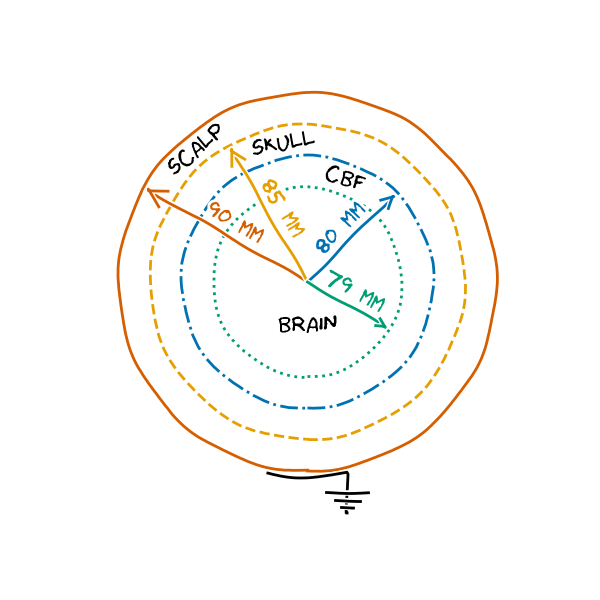

| Volume | Conductivity |
|:-------|:-------------|
| Scalp  |  330 mS / m  |
| Skull  | 16.5 mS / m  |
| CSF    | 1560 mS / m  |
| Brain  |  330 mS / m  |

# Requirements

## Memory

The code of the notebook requires at least 7.0 GB (6.6 <!-- 6.5 --> GiB) of free memory.


## Environment

1. Anaconda Python distribution (tested with _Miniconda3-py39\_4.12.0-Linux-x86\_64.sh_, _conda v. 4.12.0_).
2. Jupyter server (see _extras/jupyter\_server.sh_ for details).
3. Anaconda environments (run _setup\_conda\_envs.sh_).
4. gmsh (not necessary if you already have meshes in either MSH or XDMF format).


## Setup

### Mesh

You need to have a mesh in XDMF format.  Try:

    conda activate kesi37
    cd extras/FEM/meshes
    snakemake meshes/four_spheres_csf_1_mm_plain/normal.xdmf -j 1
    
It may take a while.  At least 5.3 GB (5 GiB) of free memory is necessary.

### Model properties

We are going to use the _extras/FEM/model\_properties/four\_spheres\_csf\_1\_mm.ini_ property file.

### Electrodes

Lets define positions of three point electrodes:

    [first]
    x = 0
    y = 0
    z = 0.0785
    
    [second]
    x = 0.01
    y = 0
    z = 0.07
    
    [third]
    x = 0.01
    y = 0.01
    z = 0.07

Write the positions as _extras/FEM/electrode\_locations/tutorial/four\_spheres.ini_.

# Preprocessing

## Calculation of the leadfield correction

For every electrode we use Finite Element Method (FEM) to calculate the leadfield correction (at least 5.5 GB of free RAM is required):

    cd extras
    python paper_solve_sphere_on_plate.py \
      --mesh FEM/meshes/meshes/four_spheres_csf_1_mm_plain/normal.xdmf \
      --degree 1 \
      --config FEM/model_properties/four_spheres_csf_1_mm.ini \
      --grounded-plate-edge-z -0.088 \
      --electrodes FEM/electrode_locations/tutorial/four_spheres.ini \
      --name first \
      --output FEM/solutions/tutorial/four_spheres/first.ini
    python paper_solve_sphere_on_plate.py \
      --mesh FEM/meshes/meshes/four_spheres_csf_1_mm_plain/normal.xdmf \
      --degree 1 \
      --config FEM/model_properties/four_spheres_csf_1_mm.ini \
      --grounded-plate-edge-z -0.088 \
      --electrodes FEM/electrode_locations/tutorial/four_spheres.ini \
      --name second \
      --output FEM/solutions/tutorial/four_spheres/second.ini
    python paper_solve_sphere_on_plate.py \
      --mesh FEM/meshes/meshes/four_spheres_csf_1_mm_plain/normal.xdmf \
      --degree 1 \
      --config FEM/model_properties/four_spheres_csf_1_mm.ini \
      --grounded-plate-edge-z -0.088 \
      --electrodes FEM/electrode_locations/tutorial/four_spheres.ini \
      --name third \
      --output FEM/solutions/tutorial/four_spheres/third.ini

> Note, that for spherical geometries a dedicated tool
> `paper_solve_sphere_on_plate.py` is used, with an
> additional parameter `--grounded-plate-edge-z`.

| Parameter  | Description  |
|:------------|:--------------|
| `--mesh`   | FEM mesh |
| `--degree` | degree of FEM elements |
| `--config` | physical model configuration (conductivity of subdomains etc.) |
| `--grounded-plate-edge-z` | Z-coordinate of the edge of the grounded plate |
| `--electrodes` | definition of electrode positions |
| `--name` | name of the electrode for which leadfield correction is to be calculated |
| `--output` | _\*.ini_ file for solution metadata (path to the file with the calculated function is the same up to the _\*.h5_ extension) |

## Sampling of the leadfield correction

We sample the correction on NxNxN grid, where `N = 2**K + 1`:

    mkdir -p FEM/solutions/tutorial/four_spheres/sampled/9/
    python paper_sample_spherical_solution.py \
      -k 9 \
      --fill 0 \
      --sampling-radius 0.079 \
      --config FEM/solutions/tutorial/four_spheres/first.ini \
      --output FEM/solutions/tutorial/four_spheres/sampled/9/first.npz
    python paper_sample_spherical_solution.py \
      -k 9 \
      --fill 0 \
      --sampling-radius 0.079 \
      --config FEM/solutions/tutorial/four_spheres/second.ini \
      --output FEM/solutions/tutorial/four_spheres/sampled/9/second.npz
    python paper_sample_spherical_solution.py \
      -k 9 \
      --fill 0 \
      --sampling-radius 0.079 \
      --config FEM/solutions/tutorial/four_spheres/third.ini \
      --output FEM/solutions/tutorial/four_spheres/sampled/9/third.npz

It may take several hours (at least 6.1 GB of free RAM is required).

> Note, that for spherical geometries a dedicated tool
> `paper_sample_spherical_solution.py` is used.

| Parameter  | Description  |
|:------------|:--------------|
| `-k`   | binary logarithm of sample number in each dimansion (which is `2**k + 1`) |
| `--fill` | fill value for points where solution cannot be sampled |
| `--sampling-radius` | radius of the sampled sphere |
| `--config` | the solution metadata |
| `--output` | file for the sampled solution |

# FRR: Fast Reciprocal Reconstructor kernel construction tools

## Electrode object

In [ ]:
import numpy as np
import scipy.interpolate as si

class Electrode(object):
    def __init__(self, filename, dx=0):
        """
        Parameters
        ----------
        
        filename : str
            Path to the sampled correction potential.
            
        dx : float
            Integration step used to calculate a regularization
            parameter of the `.leadfield()` method.
        """
        self.filename = filename
        self.dx = dx
        with np.load(filename) as fh:
            self.SAMPLING_GRID = [fh[c] for c in 'XYZ']
            self.x, self.y, self.z = fh['LOCATION']
            self.base_conductivity = fh['BASE_CONDUCTIVITY']

    @property
    def _epsilon(self):
        """
        Regularization parameter of the `.leadfield()` method.
        
        Note
        ----
        
        The 0.15 factor choice has been based on a toy numerical experiment.
        Further, more rigorous experiments are definitely recommended.
        """
        return 0.15 * self.dx

    def correction_leadfield(self, X, Y, Z):
        """
        Correction of the leadfield of the electrode
        for violation of kCSD assumptions
        
        Parameters
        ----------
        X, Y, Z : np.array
            Coordinate matrices of the same shape.
        """
        with np.load(self.filename) as fh:
            return self._correction_leadfield(fh['CORRECTION_POTENTIAL'],
                                              [X, Y, Z])

    def _correction_leadfield(self, SAMPLES, XYZ):
        return self._interpolate(SAMPLES, XYZ)
        # # if XYZ points are in nodes of the sampling grid,
        # # no time-consuming interpolation is necessary
        # return SAMPLES[self._sampling_grid_indices(XYZ)]

    def _interpolate(self, SAMPLES, XYZ):
        # The interpolation can be speeded up at the cost
        # of precision by changing the method to 'nearest'
        interpolator = si.RegularGridInterpolator(
                              self.SAMPLING_GRID,
                              SAMPLES,
                              bounds_error=False,
                              fill_value=0,
                              method='linear')
        return interpolator(np.stack(XYZ, axis=-1))
#
#     def _sampling_grid_indices(self, XYZ):
#         return tuple(np.searchsorted(GRID, COORD)
#                      for GRID, COORD in zip(self.SAMPLING_GRID, XYZ))

    def leadfield(self, X, Y, Z):
        """
        Regularized leadfield of the electrode in infinite homogenous
        isotropic medium (kCSD assumptions) of conductivity
        `.base_conductivity` S/m.
        
        Note
        ----
        
        The regularization is necessary to limit numerical integration
        errors.
        """
        return (0.25 / (np.pi * self.base_conductivity)
                / (self._epsilon
                   + np.sqrt(np.square(X - self.x)
                             + np.square(Y - self.y)
                             + np.square(Z - self.z))))

In [ ]:
electrodes = [Electrode(f'FEM/solutions/tutorial/four_spheres/sampled/9/{name}.npz')
              for name in ['first', 'second', 'third']]

## Model source

We want to use CSD bases 18mm wide ($R = 9mm$).

In [ ]:
from _common_new import SphericalSplineSourceKCSD

def get_model_source(radius, conductivity):
    spline_nodes = [radius / 3, radius]
    spline_polynomial_coefficients = [[1],
                                      [0,
                                       6.75 / radius,
                                       -13.5 / radius ** 2,
                                       6.75 / radius ** 3]]
    return SphericalSplineSourceKCSD(0, 0, 0,
                                     spline_nodes,
                                     spline_polynomial_coefficients,
                                     conductivity)

In [ ]:
SRC_R = 9e-3
BASE_CONDUCTIVITY = electrodes[0].base_conductivity

model_src = get_model_source(SRC_R, BASE_CONDUCTIVITY)

## Convolver object

In [ ]:
from _fast_reciprocal_reconstructor import Convolver

BRAIN_RADIUS = 0.079
ROMBERG_K = 5

_h_min = SRC_R * 2**(1 - ROMBERG_K)
_X = _Y = np.linspace(-BRAIN_RADIUS, BRAIN_RADIUS, int(np.floor(2 * BRAIN_RADIUS / _h_min)) + 1)
_Z = np.linspace(-SRC_R, BRAIN_RADIUS, int(np.floor((BRAIN_RADIUS + SRC_R) / _h_min)) + 1)

_pot_grid = [_X, _Y, _Z]
_csd_grid = [_X, _Y, _Z[_Z >= 0]]

convolver = Convolver(_pot_grid, _csd_grid)

for _h in convolver.steps('POT'):
    assert _h >= _h_min, f'{_h} < {_h_min}'

In [ ]:
print(convolver.csd_shape)

In [ ]:
for name in ['POT', 'CSD', 'SRC']:
    print(f'{name} grid')
    print('  shape:', convolver.shape(name))
    print('  spacing:', convolver.steps(name))

## Convolver interface

We include only CSD bases which supports fit in the brain
and which centroid lies in the upper hemisphere.

In [ ]:
from _fast_reciprocal_reconstructor import ConvolverInterfaceIndexed
from scipy.integrate import romb

ROMBERG_N = 2 ** ROMBERG_K + 1
ROMBERG_WEIGHTS = romb(np.identity(ROMBERG_N), dx=2 ** -ROMBERG_K)

SRC_MASK = ((convolver.SRC_Z > 0)
            & (np.sqrt(np.square(convolver.SRC_X)
                       + np.square(convolver.SRC_Y)
                       + np.square(convolver.SRC_Z)) < BRAIN_RADIUS - SRC_R))

In [ ]:
print(SRC_MASK.sum())

In [ ]:
convolver_interface = ConvolverInterfaceIndexed(convolver,
                                                model_src.csd,
                                                ROMBERG_WEIGHTS,
                                                SRC_MASK)

## Potential At Electrode object

### Potential At Electrode: analytical solution of the forward problem (kCSD)

In [ ]:
from _fast_reciprocal_reconstructor import PAE_Analytical

In [ ]:
pae_kcsd = PAE_Analytical(convolver_interface,
                          potential=model_src.potential)

### Potential At Electrode: numerically corrected analytical solution of the forward problem (kESI)

In [ ]:
from _fast_reciprocal_reconstructor import PAE_AnalyticalCorrectedNumerically

In [ ]:
pae_kesi = PAE_AnalyticalCorrectedNumerically(convolver_interface,
                                              potential=model_src.potential)

## Kernel constructor and cross-kernel constructor

In [ ]:
from _fast_reciprocal_reconstructor import KernelConstructor, CrossKernelConstructor

In [ ]:
kernel_constructor = KernelConstructor()

In [ ]:
CSD_MASK = np.ones(convolver.shape('CSD'),
                   dtype=bool)

In [ ]:
kernel_constructor.create_crosskernel = CrossKernelConstructor(convolver_interface,
                                                               CSD_MASK)

In [ ]:
def to_3D(CSD):
    return CSD.reshape(convolver.shape('CSD'))

# kCSD reconstructor

## Construction of kernels

In [ ]:
%%time
PHI_KCSD = kernel_constructor.create_base_images_at_electrodes(electrodes,
                                                               pae_kcsd)

In [ ]:
KERNEL_KCSD = kernel_constructor.create_kernel(PHI_KCSD)

In [ ]:
%%time
CROSSKERNEL_KCSD = kernel_constructor.create_crosskernel(PHI_KCSD)

In [ ]:
del PHI_KCSD  # the array is large and no longer needed

## Reconstructor object

In [ ]:
from kesi._verbose import _CrossKernelReconstructor as Reconstructor
from kesi._engine import _LinearKernelSolver as KernelSolver

In [ ]:
reconstructor_kcsd = Reconstructor(KernelSolver(KERNEL_KCSD),
                                   CROSSKERNEL_KCSD)

# Visualisation

In [ ]:
import matplotlib.pyplot as plt
import cbf

class CardinalPlaneVisualisation(object):
    SPHERE_RADII = [0.079, 0.080, 0.085, 0.090]

    def __init__(self,
                 grid,
                 plane_intersection,
                 dpi=35,
                 cmap=cbf.bwr,
                 amp=None,
                 length_factor=1,
                 length_unit='$m$',
                 unit_factor=1,
                 unit=''):
        self.grid = grid
        self.plane_intersection = np.array(plane_intersection)
        self.indices = [np.searchsorted(g, a)
                        for a, g in zip(plane_intersection,
                                        grid)]
        self.dpi = dpi
        self.cmap = cmap
        self.amp = amp
        self.length_factor = length_factor
        self.length_unit = length_unit
        self.unit_factor = unit_factor
        self.unit = unit

    def start_new_image(self, title, wx, wy, wz):
        self.fig = plt.figure(figsize=((wx + wy) / self.dpi,
                                       (wz + wy) / self.dpi))
        if title is not None:
            self.fig.suptitle(title)

        gs = plt.GridSpec(2, 2,
                          figure=self.fig,
                          width_ratios=[wx, wy],
                          height_ratios=[wz, wy])

        self.ax_xz = self.fig.add_subplot(gs[0, 0])
        self.ax_xz.set_aspect('equal')
        self.ax_xz.set_ylabel(f'Z [{self.length_unit}]')
        self.ax_xz.set_xlabel(f'X [{self.length_unit}]')

        self.ax_yx = self.fig.add_subplot(gs[1, 1])
        self.ax_yx.set_aspect('equal')
        self.ax_yx.set_ylabel(f'X [{self.length_unit}]')
        self.ax_yx.set_xlabel(f'Y [{self.length_unit}]')

        self.ax_yz = self.fig.add_subplot(gs[0, 1],
                                          sharey=self.ax_xz,
                                          sharex=self.ax_yx)
        self.ax_yz.set_aspect('equal')

        self.cax = self.fig.add_subplot(gs[1, 0])
        self.cax.set_visible(False)

    def finish_image(self):
        x, y, z = self.length_factor * self.plane_intersection

        self.ax_xz.axvline(x, ls=':', color=cbf.BLACK)
        self.ax_xz.axhline(z, ls=':', color=cbf.BLACK)

        self.ax_yx.axvline(y, ls=':', color=cbf.BLACK)
        self.ax_yx.axhline(x, ls=':', color=cbf.BLACK)

        self.ax_yz.axvline(y, ls=':', color=cbf.BLACK)
        self.ax_yz.axhline(z, ls=':', color=cbf.BLACK)
        self.fig.colorbar(self.im, ax=self.cax,
                          orientation='horizontal',
                          label=self.unit)

        self._add_spheres(self.SPHERE_RADII)

    def plot_volume(self, DATA, title=None, amp=None):
        self.start_new_image(title, *DATA.shape)
        ix, iy, iz = self.indices
        self._plot_planes([DATA[ix:ix+1, :, :],
                           DATA[:, iy:iy+1, :],
                           DATA[:, :, iz:iz+1],
                           ],
                           amp if amp is not None else abs(DATA).max())
        self.finish_image()

    def _plot_planes(self, DATA_PLANES, amp):
        DATA_ZY = DATA_PLANES[0][0, :, :].T * self.unit_factor
        DATA_ZX = DATA_PLANES[1][:, 0, :].T * self.unit_factor
        DATA_XY = DATA_PLANES[2][:, :, 0] * self.unit_factor
        
        def _extent(first, second):
            _first = self.grid[first] * self.length_factor
            _second = self.grid[second] * self.length_factor
            return (_first.min(), _first.max(),
                    _second.min(), _second.max())

        self.ax_xz.imshow(DATA_ZX,
                          vmin=-amp * self.unit_factor,
                          vmax=amp * self.unit_factor,
                          cmap=self.cmap,
                          origin='lower',
                          extent=_extent(0, 2))
        self.ax_yx.imshow(DATA_XY,
                          vmin=-amp * self.unit_factor,
                          vmax=amp * self.unit_factor,
                          cmap=self.cmap,
                          origin='lower',
                          extent=_extent(1, 0))
        self.im = self.ax_yz.imshow(DATA_ZY,
                                    vmin=-amp * self.unit_factor,
                                    vmax=amp * self.unit_factor,
                                    cmap=self.cmap,
                                    origin='lower',
                                    extent=_extent(1, 2))

    def plot_planes(self,
                    DATA_PLANES,
                    title=None,
                    amp=None):

        DATA_YZ, DATA_XZ, DATA_XY = DATA_PLANES
        wx, wy, _ = DATA_XY.shape
        wz = DATA_YZ.shape[2]
        assert DATA_YZ.shape[1] == wy
        assert DATA_XZ.shape[0] == wx
        assert DATA_XZ.shape[2] == wz
        
        self.start_new_image(title, wx, wy, wz)
        self._plot_planes(DATA_PLANES,
                          amp if amp is not None else max(abs(_A).max() for _A in DATA_PLANES))
        self.finish_image()

    def compare_with_gt(self, GT, CSD, title=''):
        ERROR = CSD - GT
        error_L2 = np.sqrt(np.square(ERROR).sum() / np.square(GT_CSD).sum())
        amp = max(abs(CSD).max(),
                  abs(GT).max(),
                  abs(ERROR).max())
        self.plot_volume(GT,
                         title='GT CSD',
                         amp=amp)
        self.plot_volume(CSD,
                         title=f'{title} reconstruction',
                         amp=amp)
        self.plot_volume(ERROR,
                         title=f'{title} error (GT normalized L2 norm: {error_L2:.2g})',
                         amp=amp)

    def _add_spheres(self, sphere_radii):
        for c, ax in zip(self.plane_intersection,
                         [self.ax_yz,
                          self.ax_xz,
                          self.ax_yx]):
            for r2 in np.square(sphere_radii):
                self._plot_circle(ax, np.sqrt(r2 - np.square(c)))

    def _plot_circle(self, ax, r):
        ax.add_artist(plt.Circle((0, 0), r * self.length_factor,
                                facecolor='none',
                                edgecolor=cbf.BLACK,
                                linestyle=':'))

    @property
    def PLANES_XYZ(self):
        return [[[c] if i == j else A for j, A in enumerate(self.grid)]
                for i, c in enumerate(self.plane_intersection)]

In [ ]:
csd_grid = [_x.flatten() for _x in convolver.CSD_GRID]

In [ ]:
csd_plotter = CardinalPlaneVisualisation(csd_grid,
                                         [0.01, 0, 0.065],
                                         unit_factor=1e-3,
                                         unit='$\\frac{pA}{mm^3}$',
                                         length_factor=1e3,
                                         length_unit='$mm$')

# Ground truth CSD and its potential at the electrodes

## GT CSD

In [ ]:
%%time
EIGENVALUES_KCSD, EIGENVECTORS_KCSD = np.linalg.eigh(KERNEL_KCSD)
EIGENVALUES_KCSD, EIGENVECTORS_KCSD = EIGENVALUES_KCSD[::-1], EIGENVECTORS_KCSD[:, ::-1]

GT_CSD = to_3D(reconstructor_kcsd(EIGENVECTORS_KCSD[:, 0] * 10))

In [ ]:
csd_plotter.plot_volume(GT_CSD, 'GT CSD')

## FEM forward modelling

In [ ]:
import configparser
import dolfin
import scipy.interpolate as si

import FEM.fem_common as fc

Note that the model uses a different Dirichlet boundary condition than a forward model for slice geometry.

In [ ]:
class ForwardModel(object):
    GROUNDED_PLATE_AT = -0.088

    def __init__(self, config):
        metadata = fc.MetadataReader(config)
        self.fm = fc.FunctionManager(metadata.getpath('fem', 'mesh'),
                                     metadata.getint('fem', 'degree'),
                                     metadata.get('fem', 'element_type'))
        self.config = configparser.ConfigParser()
        self.config.read(metadata.getpath('model', 'config'))

        self.V = self.fm.function_space
        mesh = self.fm.mesh

        n = self.V.dim()
        d = mesh.geometry().dim()

        self.dof_coords = self.V.tabulate_dof_coordinates()
        self.dof_coords.resize((n, d))
        
        self.csd_f = self.fm.function()
        
        self.subdomains = self.fm.load_subdomains()
        self.dx = dolfin.Measure("dx")(subdomain_data=self.subdomains)            

    @property
    def CONDUCTIVITY(self):
        for section in self.config.sections():
            if self._is_conductive_volume(section):
                yield (self.config.getint(section, 'volume'),
                       self.config.getfloat(section, 'conductivity'))

    def _is_conductive_volume(self, section):
        return (self.config.has_option(section, 'volume')
                and self.config.has_option(section, 'conductivity')) 
        
    def __call__(self, csd_interpolator):
        self.csd_f.vector()[:] = csd_interpolator(self.dof_coords)
        
        dirichlet_bc_gt = dolfin.DirichletBC(self.V,
                                     dolfin.Constant(0),
                                     (lambda x, on_boundary:
                                      on_boundary and x[2] <= self.GROUNDED_PLATE_AT))
        test = self.fm.test_function()
        trial = self.fm.trial_function()
        potential = self.fm.function()
        
        
        dx = self.dx
        a = sum(dolfin.Constant(c)
                * dolfin.inner(dolfin.grad(trial),
                               dolfin.grad(test))
                * dx(i)
                for i, c
                in self.CONDUCTIVITY)
        L = self.csd_f * test * dx
        
        b = dolfin.assemble(L)
        A = dolfin.assemble(a)
        dirichlet_bc_gt.apply(A, b)
        
        solver = dolfin.KrylovSolver("cg", "ilu")
        solver.parameters["maximum_iterations"] = 10000
        solver.parameters["absolute_tolerance"] = 1E-8
        solver.solve(A, potential.vector(), b)
        
        return potential

In [ ]:
%%time
fem = ForwardModel('FEM/solutions/tutorial/four_spheres/first.ini')

It may take more than 3 minutes.

In [ ]:
%%time
_csd = si.RegularGridInterpolator(csd_grid,
                                  GT_CSD,
                                  bounds_error=False,
                                  fill_value=0)
potential = fem(_csd)

del _csd  # the object is large and no longer needed

It may take more than 2 minutes.

We visualise the potential.

In [ ]:
potential_plotter = CardinalPlaneVisualisation(csd_grid,
                                               [0.01, 0, 0.065],
                                               unit='$\mu{}V$',
                                               length_factor=1e3,
                                               length_unit='$mm$',
                                               cmap=cbf.PRGn)

In [ ]:
%%time
V_PLANES = []

for _X, _Y, _Z in potential_plotter.PLANES_XYZ:
    with np.nditer([np.reshape(_X, (-1, 1, 1)),
                    np.reshape(_Y, (1, -1, 1)),
                    np.reshape(_Z,  (1, 1, -1)),
                    None]) as it:
        for _x, _y, _z, _res in it:
            try:
                _res[...] = potential(_x, _y, _z)
            except RuntimeError:
                _res[...] = np.nan

        V_PLANES.append(np.ma.masked_invalid(it.operands[3]))

It may take more than a minute.

In [ ]:
potential_plotter.plot_planes(V_PLANES, 'POTENTIAL')

We probe the potential at electrodes.

In [ ]:
GT_V = np.array([potential(_e.x, _e.y, _e.z) for _e in electrodes])

In [ ]:
del potential, fem  # these objects are large and no longer needed

# Reconstruction

## kCSD

In [ ]:
CSD_KCSD = to_3D(reconstructor_kcsd(GT_V))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KCSD,
                            'kCSD')

The reconstruction is mostly error.

In [ ]:
del CSD_KCSD  # the array is large and no longer needed

In [ ]:
del reconstructor_kcsd, CROSSKERNEL_KCSD  # these objects are large and no longer needed

## kESI

In [ ]:
%%time
PHI_KESI = kernel_constructor.create_base_images_at_electrodes(electrodes,
                                                               pae_kesi)

It may take more than a minute.

In [ ]:
KERNEL_KESI = kernel_constructor.create_kernel(PHI_KESI)

In [ ]:
%%time
CROSSKERNEL_KESI = kernel_constructor.create_crosskernel(PHI_KESI)

In [ ]:
del PHI_KESI  # the array is large and no longer needed

In [ ]:
reconstructor_kesi = Reconstructor(KernelSolver(KERNEL_KESI),
                                   CROSSKERNEL_KESI)

In [ ]:
CSD_KESI = to_3D(reconstructor_kesi(GT_V))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI,
                            'kESI')

The reconstruction is pretty close to the ground truth.

In [ ]:
del CSD_KESI  # the array is large and no longer needed

## Noise

As no real-world measurement is perfect, we introduce 2% noise to see, how kESI may deal with it:

In [ ]:
np.random.seed(42)
V_WITH_NOISE = np.random.normal(loc=GT_V,
                                scale=0.02*np.sqrt(np.square(GT_V).mean()))

In [ ]:
CSD_KESI_WITH_NOISE = to_3D(reconstructor_kesi(V_WITH_NOISE))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI_WITH_NOISE,
                            'kESI (noise)')

In [ ]:
del CSD_KESI_WITH_NOISE  # the array is large and no longer needed

As you can see, the quality of reconstruction decreased significatntly.

## Regularization

In [ ]:
EIGENVALUES_KESI = np.linalg.eigvalsh(KERNEL_KESI)[::-1]

In [ ]:
plt.plot(EIGENVALUES_KESI,
         marker='o')

plt.yscale('log')

In [ ]:
REGULARIZATION_PARAMETERS = np.logspace(4, 14, 10 * 10 + 1)

### Leave-one-out cross-validation

In [ ]:
from _common_new import cv

In [ ]:
%%time
CV_ERRORS = cv(reconstructor_kesi, V_WITH_NOISE, REGULARIZATION_PARAMETERS)

In [ ]:
regularization_parameter_idx = np.argmin(CV_ERRORS)
regularization_parameter = REGULARIZATION_PARAMETERS[regularization_parameter_idx]

In [ ]:
plt.plot(REGULARIZATION_PARAMETERS,
         CV_ERRORS,
         color=cbf.BLUE)
plt.axvline(regularization_parameter,
            ls=':',
            color=cbf.BLUE)
plt.xscale('log')
plt.xlabel('regularization parameter')
plt.yscale('log')
plt.ylabel('L2 norm of cross-validation error')

In [ ]:
CSD_KESI_CV = to_3D(reconstructor_kesi(V_WITH_NOISE, regularization_parameter))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI_CV,
                            'kESI (noise)')

In [ ]:
del CSD_KESI_CV  # the array is large and no longer needed

### L-curve

In [ ]:
model_norm = []
error = []
for _regularization_parameter in REGULARIZATION_PARAMETERS:
    _beta = np.linalg.solve(KERNEL_KESI + _regularization_parameter * np.identity(len(electrodes)),
                            V_WITH_NOISE)
    _V = np.matmul(KERNEL_KESI, _beta)
    error.append(np.sqrt(np.square(V_WITH_NOISE - _V).mean()))
    model_norm.append(np.dot(_beta, _V))

In [ ]:
_idx_low, _idx_high = np.searchsorted(REGULARIZATION_PARAMETERS,
                                      [EIGENVALUES_KESI.min(),
                                       EIGENVALUES_KESI.max()])
_bottom = model_norm[_idx_high]
_top = model_norm[_idx_low]
_left = error[_idx_low]
_right = error[_idx_high]

fig, ax = plt.subplots()
ax.plot(error, model_norm,
        marker='.',
        color=cbf.BLUE)
ax.add_patch(plt.Rectangle((_left, _bottom),
                           _right - _left,
                           _top - _bottom,
                           ls=':',
                           edgecolor=cbf.BLACK,
                           facecolor='none'))

ax.set_yscale('log')
ax.set_ylabel('norm of the model')
ax.set_xscale('log')
ax.set_xlabel('L2 norm of the prediction error')
ax.set_title('L-curve')


fig, ax = plt.subplots()
ax.plot(error, model_norm,
        marker='.',
        color=cbf.BLUE)
ax.plot(error[regularization_parameter_idx],
        model_norm[regularization_parameter_idx],
        marker='o',
        color=cbf.VERMILION)
ax.annotate(f'$\\lambda$ = {regularization_parameter:.2e}\n(selected by CV)',
            (error[regularization_parameter_idx],
             model_norm[regularization_parameter_idx]),
            xytext=(25, -50),
            textcoords='offset points',
            arrowprops={'facecolor': cbf.BLACK,
                        'shrink': 0.1,
                        'headwidth': 6,
                        'width': 2,
                       })

ax.set_yscale('log')
ax.set_ylabel('norm of the model')
ax.set_xscale('log')
ax.set_xlabel('L2 norm of the prediction error')
ax.set_xlim(_left, _right)
ax.set_ylim(_bottom, _top)
_ = ax.set_title('L-curve cropped to the range of eigenvalues')